<a href="https://colab.research.google.com/github/ashcat2005/lightcurve-exoplanet/blob/main/ExoplanetModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exoplanet Model

---
## Flux Model
Simple model of the flux (without limb darkening). Eq. (1) in reference [1] or Eq. (2.1) in [2].

\begin{equation}
F^e (p,z) = 1 - \lambda^e(p,z)
\end{equation}
where
\begin{equation}
\lambda^e (p,z) = 
\begin{cases}
0 & 1+p <z \\
\frac{1}{\pi} \left[ p^2 \kappa_0 + \kappa_1 - \sqrt{\frac{4z^2 - (1+z^2-p^2)^2}{4}} \right] & |1-p| <z\leq 1+p \\
p^2  & z \leq 1-p \\
1 & z \leq p-1
\end{cases}
\end{equation}
and
\begin{align}
\kappa_1 = &\cos^{-1}\left[\frac{1-p^2+z^2}{2z} \right] \\
\kappa_0 = &\cos^{-1}\left[\frac{p^2+z^2-1}{2pz} \right]
\end{align}

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def L(p, z):
  '''
  Obstruction function
  '''
  if z>1+p:
    return 0.
  elif (1-p<z and z<=1+p):
    k0 = np.arccos((p**2 + z**2 -1)/(2*p*z))
    k1 = np.arccos((1-p**2 + z**2)/(2*z))
    L0 = k0*p**2
    L2 = np.sqrt((4*z**2- (1+z**2-p**2)**2)/4) 
    return (L0 + k1 - L2)/np.pi
  elif (z>=0. and z<=1-p):
    return p**2
  elif z<= p-1: # Check this option!!
    return 1.

p = 0.1 # Ratio of sizes r_p/r_*

n=100 # Number of points in the grid
z = np.linspace(0.,1.5,n) #Values of the adimensional distance z
F = np.zeros(n) # Flux

# Determine the flux at each value of z
for i in range(n):
  F[i] = 1. - L(p,z[i])


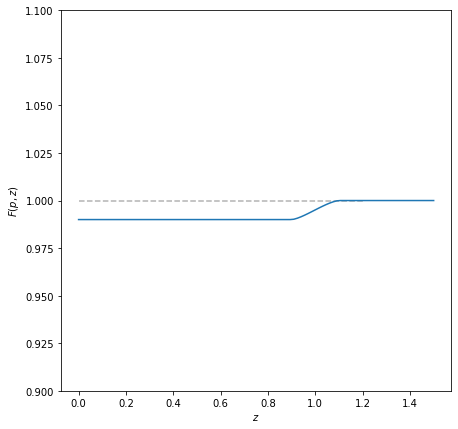

In [4]:
# Plot the Flux as function of z
plt.figure(figsize=(7,7))
plt.plot(z, F)
plt.hlines(1., 0., 1.2,linestyle='dashed', alpha=0.3)
plt.ylim(0.9,1.1)
plt.xlabel(r'$z$')
plt.ylabel(r'$F(p,z)$')
plt.show()

---
## Limb-Darkening
Simple model for the limb-darkening. Eq. (2.2) of [2].

\begin{equation}
I(r) = 1 - \gamma_1 (1-\mu) - \gamma_2 (1-\mu)^2
\end{equation}
where
\begin{equation}
\mu = \cos \theta = \sqrt{1-r^2}.
\end{equation}

In [5]:

def I(r):
  '''
  Limb-darkening function
  '''
  gamma1 = 0.5 
  gamma2 = 0.1
  mu = np.sqrt(1-r**2) 
  return 1. - gamma1*(1-mu) - gamma2*(1-mu)**2

# Saptial grid
n = 100
r = np.linspace(0., 1., n)

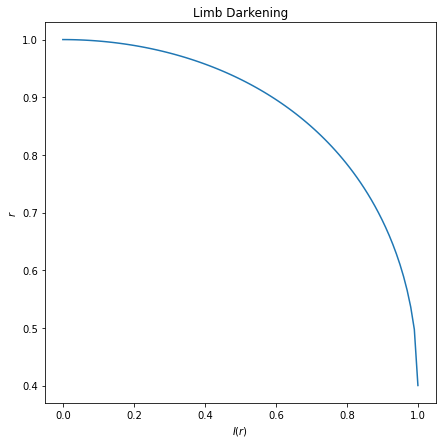

In [6]:
#Plot the limb-darkening function
plt.figure(figsize=(7,7))
plt.plot(r, I(r))
plt.title(r'Limb Darkening')
plt.xlabel(r'$I(r)$')
plt.ylabel(r'$r$')
plt.show()

---
## Quadratic Limb Darkening

## Flux with quadratic limb darkening through numerical integration

The paper has problems in the analytic solutions of the integrals of the flux, so it was decided to obtain the theoretical curve by the direct numerical integration in the equation of the flux.

\begin{equation}
F(p,z) = \left[ \int_0^1 dr 2r I(r)\right]^{-1} \int_0^1 dr I(r) \frac{d\left[ F^e \left(\frac{p}{r}, \frac{z}{r} \right) r^2 \right]}{dr}
\end{equation}

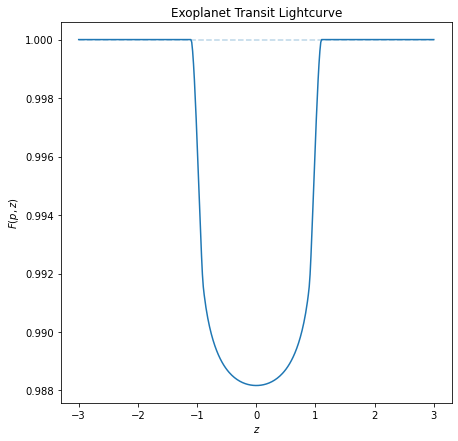

In [9]:
# Quadratic Limb Darkening Model

from scipy.misc import derivative
import scipy.integrate as integrate
import numpy as np
import matplotlib.pyplot as plt

def L(r, P, Z):
  '''
  Obstruction function
  '''
  p = P/r
  z0 = Z/r
  
  # Reflects the information w.r.t. the y axis  
  if z0>0:
    z = z0
  if z0<0:
    z = -z0
    
  if z>1+p:
    return 0.
  elif (abs(1-p)<z and z<=1+p):
    k0 = np.arccos((p**2 + z**2 -1)/(2*p*z))
    k1 = np.arccos((1-p**2 + z**2)/(2*z))
    L0 = k0*p**2
    L2 = np.sqrt((4*z**2- (1+z**2-p**2)**2)/4) 
    return (L0 + k1 - L2)*r**2/np.pi
  elif (z<=1-p):
    return p**2*r**2
  elif z<= p-1: # Check this option!!
    return 1.*r**2


def I_function(r):
  '''
  Quadratic limb-darkening function
  '''
  mu = np.sqrt(1-r**2) 
  return 1. - gamma1*(1-mu) - gamma2*(1-mu)**2


def integrand_1(r, p, z):
  '''
  Integrand in the numerator
  '''
  T1 = derivative(L, r, dx=1e-6, args=(p,z))
  T2 = I_function(r)
  return T1*T2


def integrand_2(r):
  '''
  Integrand in the denominator
  '''
  return I_function(r)*2*r

# Parameters for the model
gamma1 = 0.296 
gamma2 = 0.34
p=0.1

# Discretization grid
N = 400
z_max = 3.
z_min = - z_max
z_range = np.linspace(z_min,z_max,N)

# Flux
F = np.zeros(N)

# Main Loop to calculate the Flux
for i in range(N):
  Integral_1 = integrate.quad(integrand_1, 0.0001, 1., args=(p,z_range[i]))[0]
  Integral_2 = integrate.quad(integrand_2, 0.0001, 1.)[0]
  F[i] = 1. - Integral_1/Integral_2

# Plot the Flux as function of z
plt.figure(figsize=(7,7))
plt.plot(z_range, F)
plt.hlines(1., z_min, z_max,linestyle='dashed', alpha=0.3)
plt.xlabel(r'$z$')
plt.ylabel(r'$F(p,z)$')
plt.title('Exoplanet Transit Lightcurve')
plt.show()

## Orbital model

### Circular orbit

For a circular orbit we have that the radial velocity of the planet around the star behaves as

\begin{equation}
    V_R(t) = K \cdot sin\left(\frac{2 \pi}{P}t+t_0\right) + V_{R0} 
\end{equation}

where $t$ is the time, $K$ is the absolute of the maximum radial velo city, $P$ is the period of the orbit, $t_0$
is the phase and $V_{R0}$ is the radial velo city of the system's center of mass.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def radial_velocity(K, P, t, t_0 = 0, V_R0 = 0):
    """
    By default t_0 = 0 and V_R0 = 0
    """
    return K*np.sin((2*np.pi/P)*t+t_0) + V_R0



## Initial Parameters

|Parameter | value|
|---|---|
|Radius ratio | $\frac{R_p}{R_*}$  |
|Impact parameter| $b$|
|Linear limb darkening parameter| $\gamma_1$|
|Quadratic limb darkening parameter| $\gamma_2$|
|Semi-major axis|$\frac{a}{R_*}$|
|Orbital period|T|
|Orbital phase|$\delta$|

Coordinate $z$ as function of time $t$,

\begin{equation}
z(t) =  a \cos (\omega t + \delta)
\end{equation}

where
\begin{equation}
\omega = \frac{2\pi}{T}
\end{equation}

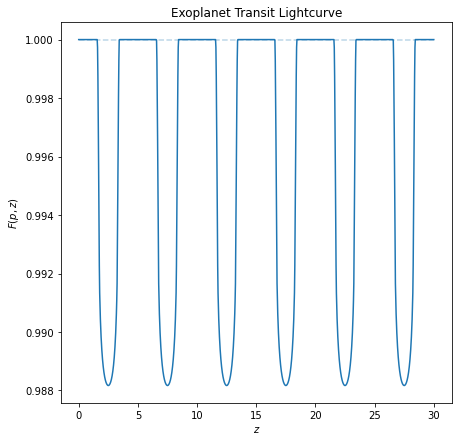

In [4]:
from scipy.misc import derivative
import scipy.integrate as integrate
import numpy as np
import matplotlib.pyplot as plt

def L(r, P, Z):
  '''
  Obstruction function
  '''
  p = P/r
  z0 = Z/r
  
  # Reflects the information w.r.t. the y axis  
  if z0>0:
    z = z0
  if z0<0:
    z = -z0
    
  if z>1+p:
    return 0.
  elif (abs(1-p)<z and z<=1+p):
    k0 = np.arccos((p**2 + z**2 -1)/(2*p*z))
    k1 = np.arccos((1-p**2 + z**2)/(2*z))
    L0 = k0*p**2
    L2 = np.sqrt((4*z**2- (1+z**2-p**2)**2)/4) 
    return (L0 + k1 - L2)*r**2/np.pi
  elif (z<=1-p):
    return p**2*r**2
  elif z<= p-1: # Check this option!!
    return 1.*r**2


def I_function(r):
  '''
  Quadratic limb-darkening function
  '''
  mu = np.sqrt(1-r**2) 
  return 1. - gamma1*(1-mu) - gamma2*(1-mu)**2


def integrand_1(r, p, z):
  '''
  Integrand in the numerator
  '''
  T1 = derivative(L, r, dx=1e-6, args=(p,z))
  T2 = I_function(r)
  return T1*T2


def integrand_2(r):
  '''
  Integrand in the denominator
  '''
  return I_function(r)*2*r



# Parameters for the model
p=0.1 #radius ratio
gamma1 = 0.296 #linear limb darkening 
gamma2 = 0.34 #quadratic limb darkening
a = 2. #semi-major axis
T = 10. #orbital period
delta = 0. #orbital phase
omega = 2*np.pi/P #angular velocity

# Grid definition
N = 1000
t = np.linspace(0.,30,N)
z_range = a*np.cos(omega*t+delta)


# Flux
F = np.zeros(N)

# Main Loop to calculate the Flux
for i in range(N):
  Integral_1 = integrate.quad(integrand_1, 0.0001, 1., args=(p,z_range[i]))[0]
  Integral_2 = integrate.quad(integrand_2, 0.0001, 1.)[0]
  F[i] = 1. - Integral_1/Integral_2

# Plot the Flux as function of z
plt.figure(figsize=(7,7))
plt.plot(t, F)
plt.hlines(1., t[0], t[-1],linestyle='dashed', alpha=0.3)
plt.xlabel(r'$z$')
plt.ylabel(r'$F(p,z)$')
plt.title('Exoplanet Transit Lightcurve')
plt.show()

---
## References


1. K. Mandel and E. Agol. *Analytic Lightcurves for Planetary Transit Searches*. [astro-ph:0210099](https://arxiv.org/pdf/astro-ph/0210099.pdf).

2. [Modelling Exoplanets by D. Compton, D. Juncher and N. Vinyoles](https://phys.au.dk/fileadmin/Project_updated_gr.1.pdf)

3. S. Seager and G. Mallén-Ornelas. *On the Unique Solution of Planet and Star Parameters from an Extrasolar Planet Transit Light Curve*. [astro-ph:0206228](https://arxiv.org/pdf/astro-ph/0206228.pdf)